In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from collections import namedtuple 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
date = namedtuple('Date', 'month day')

In [3]:
sns.set()

In [4]:
#Функция вычисления центроидов всех кластеров 
def centroids(data, clusters):
    n = np.unique(clusters)
    dist = []
    for i in n:
        matrix = data.values[np.where(clusters == i)]
        dist.append(np.sum(matrix, axis=0) / matrix.shape[0])
    return np.array(dist)

#Расстояние между цетроидами кластеров (на вход матрица цетроидов) 
def cluster_dist(matrix):
    size = matrix.shape[0]
    av_dist = [sum((euclid(matrix[i], matrix[j]) for j in range(i, size))) for i in range(size)]
    return sum(av_dist)/ len(av_dist)

#Функция вычисления среднего расстояния между кластерами  
av_dist = lambda df, cl: cluster_dist(centroids(df, cl))

#Евклидово расстояние
euclid = lambda x, y: np.sqrt(np.sum((x - y)**2))

def plot(*args):
    plt.figure(figsize=(20, 6))
    for arg in args:
        plt.plot(arg.T)
    plt.title('Data Example')
    plt.show()

    
s1 = [pd.datetime(2017, 9, 1), pd.datetime(2018, 9, 1)]
d31 = [pd.datetime(2017, 12, 31), pd.datetime(2018, 12, 31)]
f14 = [pd.datetime(2018, 2, 14), pd.datetime(2019, 2, 14)]
f23 = [pd.datetime(2018, 2, 23), pd.datetime(2019, 2, 23)]
m8 = [pd.datetime(2018, 3, 8), pd.datetime(2019, 3, 8)]
allhol = [s1, d31, f14, f23, m8]
colors = ['b', 'g', 'r', 'm', 'c']    

def plot_clust(data, clusters, lines=100):
    centroid = centroids(data, clusters)
    n = np.unique(clusters)
    fig = plt.figure(figsize=(20, 400))
    for i in n:
        plt.subplot(len(n), 1, i+1)
        plt.title(f'cluster {i}, {clusters[clusters==i].count()} items')
        for j, color in zip(allhol, colors):
            plt.axvline(j[0], c=color, label=j[0])
            plt.axvline(j[1], c=color, label=j[1])
        idx = np.where(clusters == i)[0][:lines]
        plt.plot(data.columns, centroid[i], c='red')
        for j in idx:
            plt.plot(data.T.iloc[:, j], c='black', alpha=0.05) 

def save_clust(data, clusters, model, lines=100):
    centroid = centroids(data, clusters)
    n = np.unique(clusters)
    fig = plt.figure(figsize=(20, 400))
    for i in n:
        plt.subplot(len(n), 1, i+1)
        plt.title(f'cluster {i}, {clusters[clusters==i].count()} items')
        for j, color in zip(allhol, colors):
            plt.axvline(j[0], c=color, label=j[0])
            plt.axvline(j[1], c=color, label=j[1])
        idx = np.where(clusters == i)[0][:lines]
        plt.plot(data.columns, centroid[i], c='red')
        for j in idx:
            plt.plot(data.T.iloc[:, j], c='black', alpha=0.05)
    plt.savefig(fname=f'results/{model}.png', bbox_inches='tight')
    plt.close(fig)
            
def metrics_values(data, clusters):
    metrics = {'Average Distance': av_dist(data, clusters),
#                 'Silhouette score': silhouette_score(data, clusters),
#                 'Calinski-Harabasz score': calinski_harabasz_score(data, clusters),
                'Davies bouldin score': davies_bouldin_score(data, clusters)}
    return metrics
    

In [5]:
df = pd.read_csv(r'st_ts.txt', index_col='id')
df = np.log(1.1 + df).T
df.index = pd.DatetimeIndex(df.index)
scale = StandardScaler()
sc_df = pd.DataFrame(scale.fit_transform(df).T, index=df.columns, columns=df.index)

In [6]:
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'fall': [9, 10, 11]
}

In [7]:
dates = {
    '31d': date(12, 31),
    '1s': date(9, 1),
    '14f': date(2, 14),
    '23f': date(2, 23),
    '8m': date(3, 8)
}

In [8]:
def extract_dates_by_years(df, celeb, year, n_days):
    date = pd.datetime(year=year, month=dates[celeb].month, day=dates[celeb].day)
    sum1 = df[df.index <= date][-n_days:].sum()
    sum2 = df[df.index > date][:n_days].sum()
    return sum1 / sum2
    

In [9]:
# def extract_dates(df, celeb, n_days):
#     years = df.index.year.unique()
#     sum1 = 0
#     sum2 = 0
#     for year in years:
#         date = pd.datetime(year=year, month=dates[celeb].month, day=dates[celeb].day)
#         sum1 += df[df.index <= date][-n_days:].sum().sum()
#         sum2 += df[df.index > date][:n_days].sum().sum()
#         print(year, sum1, sum2)

In [10]:
def extract_seasons(df, season1, season2):
    sum1 = df[df.index.month.isin(seasons[season1])].sum()
    sum2 = df[df.index.month.isin(seasons[season2])].sum()
    return sum1 / sum2

In [11]:
def extract_seasons_by_years(df, year, season1, season2):
    if season1 == 'winter':
        sum1 = df[(df.index.month.isin(seasons[season1]))  & (df.index.year.isin([year, year-1])) & (df.index < f'{year}-03-01')].sum()
        sum2 = df[(df.index.month.isin(seasons[season2]))  & (df.index.year == year)].sum()
        return sum1 / sum2
    if season2 == 'winter':
        sum1 = df[(df.index.month.isin(seasons[season1]))  & (df.index.year == year)].sum()
        sum2 = df[(df.index.month.isin(seasons[season2]))  & (df.index.year.isin([year, year-1])) & (df.index < f'{year}-03-01')].sum()
        return sum1 / sum2
    sum1 = df[(df.index.month.isin(seasons[season1]))  & (df.index.year == year)].sum()
    sum2 = df[(df.index.month.isin(seasons[season2]))  & (df.index.year == year)].sum()
    return sum1 / sum2

In [12]:
season_feat = [extract_seasons(df, 'winter', 'summer'), extract_seasons(df, 'winter', 'spring'),
            extract_seasons(df, 'winter', 'fall'), 
            extract_seasons(df, 'summer', 'spring'), extract_seasons(df, 'summer', 'fall'),
            extract_seasons(df, 'summer', 'winter'),
            extract_seasons(df, 'fall', 'spring')]

day_feat = [extract_dates_by_years(df, '31d', 2017, 2),
            extract_dates_by_years(df, '31d', 2017, 3), extract_dates_by_years(df, '31d', 2017, 4),
            extract_dates_by_years(df, '31d', 2017, 5),
            extract_dates_by_years(df, '31d', 2018, 2),
            extract_dates_by_years(df, '31d', 2018, 3), extract_dates_by_years(df, '31d', 2018, 4),
            extract_dates_by_years(df, '31d', 2018, 5), 
           extract_dates_by_years(df, '1s', 2017, 1), extract_dates_by_years(df, '1s', 2017, 2),
            extract_dates_by_years(df, '1s', 2018, 2),
            extract_dates_by_years(df, '1s', 2018, 3), extract_dates_by_years(df, '1s', 2018, 4),
           extract_dates_by_years(df, '14f', 2018, 1), extract_dates_by_years(df, '14f', 2019, 1),
           extract_dates_by_years(df, '23f', 2018, 1), extract_dates_by_years(df, '23f', 2019, 1),
           extract_dates_by_years(df, '8m', 2018, 1), extract_dates_by_years(df, '8m', 2019, 1)]



In [13]:
columns1 =['wintersummer', 'winterspring', 'winterfall', 'summerspring', 'summerfall', 'summerwinter', 
          'fallspring']

In [14]:
columns2 = ['31d17-2', '31d17-3', '31d17-4','31d17-5','31d18-2','31d18-3','31d18-4', '31d18-5',
           '1s17-1', '1s18-2', '1s18-2', '1s18-3', '1s18-4', '14f18-1', '14f19-1', '23f19-1', '23f19-1',
           '8m18-1', '8m19-1']

In [15]:
df_dates = pd.DataFrame(day_feat).T
df_dates = pd.DataFrame(scale.fit_transform(df_dates), index=sc_df.index, columns=columns2)

In [16]:
df_seasons = pd.DataFrame(season_feat).T
df_seasons = pd.DataFrame(scale.fit_transform(df_seasons), index=df_seasons.index, columns=columns1)

In [17]:
# from itertools import chain, combinations

# def powerset(iterable):
#     s = list(iterable)
#     return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
# par = list(powerset(df_seasons.columns))[1:]
# for col in par:
#     model = KMeans(n_clusters=40, max_iter=1000, n_jobs=-1)
#     clusters = pd.Series(model.fit_predict(df_seasons[list(col)].join(df_dates)), index=sc_df.index)
#     print(col)
#     print(metrics_values(sc_df, clusters))
#     save_clust(sc_df, clusters, str(col), 1)

23    57270
3     22611
31    15602
13    14267
10    14116
14    11762
5     11706
32    11244
1     11046
37    10753
38    10642
16    10403
27     9322
7      9227
30     8609
39     7663
21     7450
22     7125
25     6050
24     5198
9      5068
11     4658
26     4360
8      4226
2      3954
19     3907
17     3892
6      3875
12     3869
35     3134
15     3076
36     3040
28     2693
4      2553
20     2479
0      2160
29     1661
18     1547
33     1287
34      261
dtype: int64


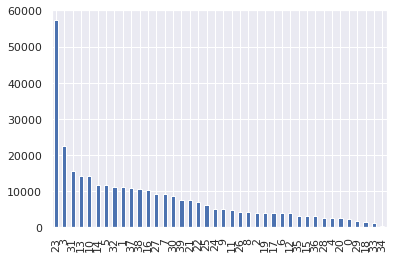

CPU times: user 670 ms, sys: 265 ms, total: 935 ms
Wall time: 50.5 s


In [18]:
%%time
clusters = pd.Series(KMeans(n_clusters=40, \
max_iter=1000, n_jobs = -1).fit_predict(df_seasons[list(('wintersummer', 'winterspring', 'winterfall', 'summerfall', 'summerwinter', 'fallspring'))].join(df_dates)), index = sc_df.index)

print(clusters.value_counts())
clusters.value_counts().plot.bar()
plt.show()

CPU times: user 2.77 s, sys: 2.09 s, total: 4.86 s
Wall time: 1.71 s


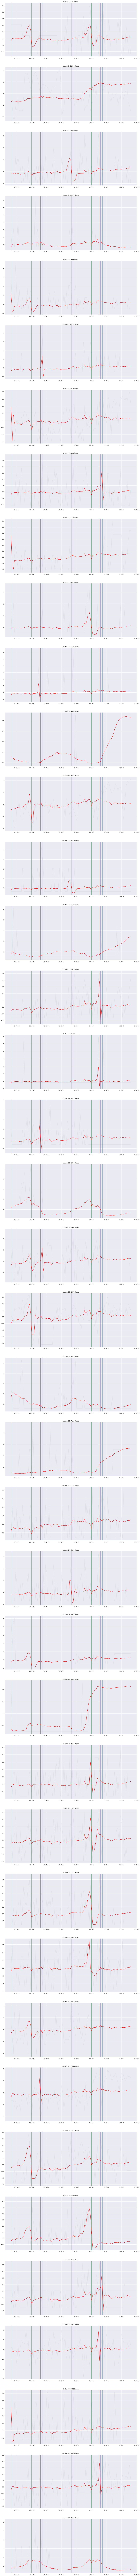

In [19]:
%%time
plot_clust(sc_df, clusters, 1)

In [13]:
print(metrics_values(sc_df, clusters))

NameError: name 'clusters' is not defined

('wintersummer', 'winterspring', 'winterfall', 'summerspring', 'summerfall', 'summerwinter', 'fallspring')
9.5
('wintersummer', 'winterspring', 'winterfall', 'summerfall', 'summerwinter', 'fallspring')
7